In [78]:
import numpy as np
import torch
print("CUDA :", torch.cuda.is_available())
print("number of GPU :", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name :", torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import trange

torch.manual_seed(0)

import random


CUDA : True
number of GPU : 1
GPU name : NVIDIA GeForce RTX 3060 Ti


In [77]:
class TicTacToe:

    def __init__(self):
        self.row_count = 3
        self.column_count = 3
        self.action_size = self.row_count * self.column_count

    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = player
        return state
    
    def get_valid_moves(self, state):
        return (state.reshape(-1) == 0).astype(np.uint8)
        
    def check_win(self, state, action):

        if action is None:
            return False

        row = action // self.row_count
        column = action % self.column_count
        player = state[row, column]

        # check row
        if np.all(state[row, :] == player):
            return True

        # check column
        if np.all(state[:, column] == player):
            return True
        
        # check diagonal
        if row == column and np.all(np.diag(state) == player):
            return True

        # check anti-diagonal
        if row + column == self.row_count - 1 and np.all(np.diag(np.fliplr(state)) == player):
            return True
        
        return False

    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False
    
    def get_opponent(self, player):
        return -player

    def get_opponent_value(self, value):
        return -value

    def change_perspective(self, state, player):
        return state * player

    def get_encoded_state(self, state):
        encoded_state = np.stack((state == 1, state == 0, state == -1)).astype(np.float32)
        return encoded_state


In [76]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, device):
        super(ResNet, self).__init__()

        self.device = device

        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size = 3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
            )

        self.backBone = nn.ModuleList([ResBlock(num_hidden) for i in range(num_resBlocks)])

        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*game.row_count * game.column_count, game.action_size)
            )
        
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size = 3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3*game.row_count*game.column_count, 1),
            nn.Tanh()
            )
        
        self.to(device)
    
    def forward(self, x):
        x = self.startBlock(x)
        for block in self.backBone:
            x = block(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value


class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size = 3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size = 3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return self.relu(out + x)

In [75]:
class Node:
    def __init__(self, game, args, state, parent= None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior # probability of selecting this node (from the policy)

        self.children = []

        self.value_sum = 0
        self.visit_count = visit_count
    
    def is_expanded(self):
        return len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.calculate_ucb(child)
            if ucb > best_ucb:
                best_ucb = ucb
                best_child = child
        
        return best_child

    def calculate_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2 
        return q_value + self.args['C'] * np.sqrt((self.visit_count) / (child.visit_count + 1)) * child.prior

    def expand(self, policy):

        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)
                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)

        return child
    
    
    def backpropagation(self, value):
        node = self
        while node is not None:
            node.visit_count += 1
            node.value_sum += value

            value = self.game.get_opponent_value(value)
            node = node.parent

class MCTS_alpha_zero:

    def __init__(self, game, args,model):
        self.game = game
        self.args = args
        self.model = model
    
    # Use for prediction, not training
    @torch.no_grad()
    def search(self, state):

        root = Node(self.game, self.args, state, visit_count=1)
        
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis = 1).squeeze(0).detach().cpu().numpy()

        # add some noise to the policy to encourage exploration (dirichlet noise)
        policy = (1 - self.args['epsilon']) * policy + self.args['epsilon'] * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)

        valid_moves = self.game.get_valid_moves(state)
        policy = policy * valid_moves

        # renormalize
        policy = policy / np.sum(policy)

        root.expand(policy)
    


        for search in range(self.args['num_searches']):

            node = root

            while node.is_expanded():

                node = node.select()

            
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)
            
            if not is_terminal:
                
                # Update the node according to the policy
                # unsqueeze to add a batch dimension
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state), device=self.model.device).unsqueeze(0) 
               )

                policy = torch.softmax(policy, axis = 1).squeeze(0).detach().cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy = policy * valid_moves
                # renormalize
                policy = policy / np.sum(policy)
                
                # get the float value
                value = value.item()
                
                node.expand(policy)
            
            # backpropagation (iterative)
            node.backpropagation(value)

        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs = action_probs / np.sum(action_probs)
        
        return action_probs

In [40]:
tictactoe = TicTacToe()

state = tictactoe.get_initial_state()
state = tictactoe.get_next_state(state, 2, 1)
state = tictactoe.get_next_state(state, 7, -1)

print(state)

encoded_state = tictactoe.get_encoded_state(state)

print(encoded_state)

tensor_state = torch.tensor(encoded_state).unsqueeze(0)

model = ResNet(tictactoe, 4, 64)

policy, value = model(tensor_state)
value = value.item()
policy = policy

print(value, policy)

[[ 0.  0.  1.]
 [ 0.  0.  0.]
 [ 0. -1.  0.]]
[[[0. 0. 1.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 1. 0.]
  [1. 1. 1.]
  [1. 0. 1.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 1. 0.]]]
0.23799026012420654 tensor([[0.2490, 0.0741, 0.0778, 0.0695, 0.1586, 0.1658, 0.0673, 0.0936, 0.0443]],
       grad_fn=<SoftmaxBackward0>)


In [81]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS_alpha_zero(game, args, model)
    
    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()

        while True:
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state)

            memory.append([neutral_state, action_probs, player])

            temperature_action_probs = action_probs ** (1 / self.args['temperature'])
            temperature_action_probs /= np.sum(temperature_action_probs)

            action = np.random.choice(self.game.action_size, p=temperature_action_probs)

            state = self.game.get_next_state(state, action, player)

            value, is_terminal = self.game.get_value_and_terminated(state, action)

            if is_terminal:
                returnMemory = []
                for hist_neutral_state, hist_action_probs, hist_player in memory:

                    # adapt, more general and work for 1 player game
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    
                    returnMemory.append([
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ])
                return returnMemory
            
            player = self.game.get_opponent(player)




    def train(self, memory):
        
        random.shuffle(memory)

        for batchidx in range(0, len(memory), self.args['batch_size']):
            batch = memory[batchidx:min(len(memory) + 1,batchidx+self.args['batch_size'])]

            # list of list, convert to tensor, these are the targets for policy and value
            states, action_probs, outcomes = zip(*batch)

            states, action_probs, outcomes = np.array(states), np.array(action_probs), np.array(outcomes).reshape(-1, 1)

            states = torch.tensor(states, dtype=torch.float32, device=self.model.device)
            action_probs = torch.tensor(action_probs, dtype=torch.float32, device=self.model.device)
            outcomes = torch.tensor(outcomes, dtype=torch.float32, device=self.model.device)
            
            self.optimizer.zero_grad()

            policy, value = self.model(states)

            value_loss = F.mse_loss(value, outcomes)
            policy_loss = F.cross_entropy(policy, action_probs)

            loss = value_loss + policy_loss

            loss.backward()
            self.optimizer.step()




    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []
            
            self.model.eval()

            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay()

            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)

            torch.save(self.model.cpu().state_dict(), f'model_{iteration}.pth')
            torch.save(self.optimizer.state_dict(), f'optimizer_{iteration}.pth')
            self.model

In [ ]:
tictactoe = TicTacToe()
player = 1

args = {
    'num_searches': 1000,
    'C': 2
}

model = ResNet(tictactoe, 4, 64)
model.eval()


mcts = MCTS_alpha_zero(tictactoe, args, model)

state = tictactoe.get_initial_state()

while True:
    print(state)

    if player == 1:

        valid_moves = tictactoe.get_valid_moves(state)
        print("valid moves :", str([i for i in range(tictactoe.action_size) if i in valid_moves]))
        action = int(input(f"{player} :"))

        if valid_moves[action] == 0:
            print("invalid move")
            continue
    else:
        neutral_state = tictactoe.change_perspective(state, player=-1)
        mcts_probs = mcts.search(state)
        action = np.argmax(mcts_probs)

    state = tictactoe.get_next_state(state, action, player)

    value, is_terminal = tictactoe.get_value_and_terminated(state, action)

    if is_terminal:
        print(state)
        if value == 1:
            print(f"{player} win")
        else:
            print("draw")
        break

    player = tictactoe.get_opponent(player)


In [82]:
tictactoe = TicTacToe()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet(tictactoe, 4, 64, 'cpu')


# temperature ->  eploitation / exploration tradeoff, same role as gamma in Q-learning. High temperature -> more exploration (rd distribution), low temperature -> more exploitation (peak distribution)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)



args = {
    'C': 2,
    'num_searches': 60,
    'num_iterations': 3,
    'num_selfPlay_iterations': 500,
    'num_epochs': 4,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_alpha': 0.3,
    'epsilon': 0.25
}


alphaZero = AlphaZero(model, optimizer, tictactoe, args)

# training
alphaZero.learn()

100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


0.9779109358787537
[[ 0.  0. -1.]
 [ 0. -1.  0.]
 [ 1.  0.  1.]]
tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [1., 0., 1.]],

         [[1., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[0., 0., 1.],
          [0., 1., 0.],
          [0., 0., 0.]]]])


C:\Users\gprad\AppData\Local\Temp\ipykernel_20308\3279724620.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_2.pth'))


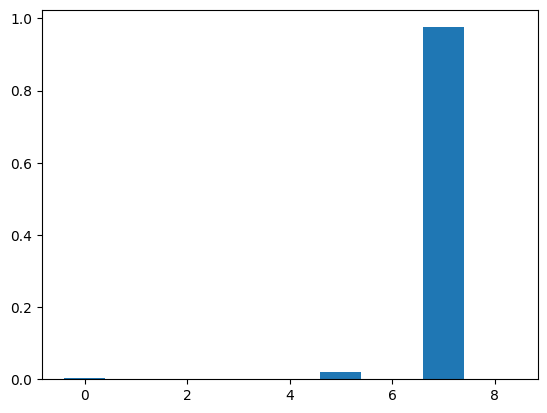

In [63]:
import matplotlib.pyplot as plt

tictactoe = TicTacToe()

state = tictactoe.get_initial_state()
state = tictactoe.get_next_state(state, 2, -1)
state = tictactoe.get_next_state(state, 4, -1)
state = tictactoe.get_next_state(state, 6, 1)
state = tictactoe.get_next_state(state, 8, 1)


encoded_state = tictactoe.get_encoded_state(state)

tensor_state = torch.tensor(encoded_state).unsqueeze(0)

model = ResNet(tictactoe, 4, 64)
model.load_state_dict(torch.load('model_2.pth'))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)

print(state)
print(tensor_state)

plt.bar(range(tictactoe.action_size), policy)
plt.show()